<a href="https://colab.research.google.com/github/ramajoballester/mil_deeplearning/blob/main/1_introduccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sesión 1. Introducción al Deep Learning

# Introducción

En solo los últimos cinco años, el Aprendizaje Profundo (*Deep Learning*) ha impulsado un rápido progreso en campos tan diversos como la visión por ordenador, el procesamiento del lenguaje natural, el reconocimiento automático del habla, el aprendizaje por refuerzo y la informática biomédica. Además, el éxito del aprendizaje profundo en tantas tareas de interés ha catalizado incluso desarrollos en el aprendizaje automático teórico y la estadística. Con estos avances en la mano, ahora podemos construir coches que se conducen solos con más autonomía que nunca (y menos autonomía de lo que algunas empresas podrían hacer creer), sistemas de respuesta inteligente que redactan automáticamente los correos electrónicos más mundanos y máquinas que dominan a los mejores humanos del mundo en juegos de mesa como el Go, una hazaña que antes se creía que estaba a décadas de distancia. Estas herramientas ya ejercen un impacto cada vez mayor en la industria y la sociedad, cambiando la forma de hacer películas, diagnosticar enfermedades y desempeñando un papel cada vez más importante en las ciencias básicas, desde la astrofísica hasta la biología.

Hablar sobre Cap. 1

## Instalación de librerías (quitar?)

In [ ]:
! pip install -q wandb
! pip install -q --upgrade albumentations
! pip install -q ipympl

     |████████████████████████████████| 102 kB 5.8 MB/s 
     |████████████████████████████████| 47.8 MB 1.4 MB/s 


In [ ]:
!pip install --upgrade -q gspread

In [ ]:
import gspread
import pandas as pd
from google.colab import auth
auth.authenticate_user()
from google.auth import default

In [ ]:
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
url = 'https://docs.google.com/spreadsheets/d/1rDJQgihE4bvVNGmPjT8sH5mCRrbOfNcEFf8KZoxZ870/edit?usp=sharing'
worksheet = gc.open_by_url(url)

In [ ]:
a = float(worksheet.sheet1.get('C5')[0][0])

In [ ]:
a

0.954782

In [ ]:
row = 5
col = 3
value = 0.954782
worksheet.sheet1.update_cell(row, col, value);

# Regresión lineal

## Implementación desde cero

La regresión lineal es un modelo matemático que aproxima la relación entre una o más variables independientes y una variable dependiente. En las ciencias naturales y sociales, el objetivo de la regresión suele ser caracterizar la relación entre las entradas y las salidas. El aprendizaje automático, en cambio, se ocupa más a menudo de la predicción.

Los problemas de regresión surgen siempre que queremos predecir un valor numérico. Algunos ejemplos comunes son la predicción de precios (de viviendas, acciones, etc.), la predicción de la duración de la estancia (para los pacientes en el hospital), la previsión de la demanda (para las ventas al por menor), entre otros innumerables. No todos los problemas de predicción son problemas clásicos de regresión. En los problemas de clasificación, por ejemplo, el objetivo es predecir la pertenencia a un conjunto de categorías.

Más sobre teoría detrás de reg. lineal?

In [1]:
import random
import torch
# %matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

In [2]:
def synthetic_data(w, b, noise, num_examples):
    """Generar y = Xw + b + ruido"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, noise, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2.0])
true_b = 4.2
noise = 0.5
features, labels = synthetic_data(true_w, true_b, noise, 1000)

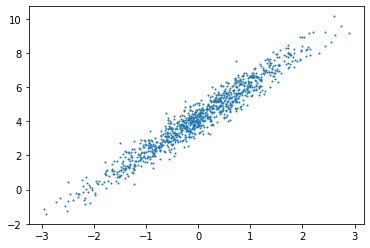

In [ ]:
plt.scatter(features[:, 0], labels, 1);

In [ ]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [ ]:
batch_size = 8

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.5878],
        [ 0.7563],
        [-0.7238],
        [-0.8571],
        [ 1.7229],
        [ 0.3907],
        [-0.9360],
        [ 0.4381]]) 
 tensor([[3.5591],
        [5.6308],
        [3.1466],
        [2.5750],
        [7.4162],
        [5.1642],
        [2.5212],
        [4.5701]])


In [ ]:
def linreg(X, w, b):
    """Modelo de regresión lineal"""
    return torch.matmul(X, w) + b

In [ ]:
def squared_loss(y_pred, y):
    """Función de pérdida Squared Loss"""
    return (y_pred - y.reshape(y_pred.shape)) ** 2 / 2

In [2]:
def sgd(params, lr, batch_size):
    """Descenso de gradiente estocástico"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

$$\hat{y} = w_1  x_1 + ... + w_d  x_d + b.$$

$$\hat{y} = \mathbf{w}^\top \mathbf{x} + b.$$

Función de pérdida
$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\color{Salmon}{\hat{y}^{(i)}} - y^{(i)}\right)^2$$

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\color{Salmon}{\mathbf{w}^\top \mathbf{x}^{(i)} + b} - y^{(i)}\right)^2$$

Descenso de gradiente
$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\alpha}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b)$$

GD para $w$
$$\mathbf{w} \leftarrow \mathbf{w} - \frac{\alpha}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b) = \mathbf{w} - \frac{\alpha}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)$$

GD para $b$
$$b \leftarrow b -  \frac{\alpha}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_b l^{(i)}(\mathbf{w}, b)  = b - \frac{\alpha\\}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)$$

fit-linreg.svg

In [ ]:
w = torch.normal(0, 0.01, size=(len(true_w),1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# Learning rate
lr = 0.01
# Número de epochs de entrenamiento
num_epochs = 5
# Modelo a optimizar
net = linreg
# Función de pérdida cuadrática
loss = squared_loss

w_history = [w.item()]
b_history = [b.item()]

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        # Pérdida entre predicción del modelo y los valores reales y
        l = loss(net(X, w, b), y)
        # Cálculo de los gradientes (derivadas) de la función de pérdida respecto
        # de los parámetros del modelo
        l.sum().backward()
        # Actualización de los parámetros según sus gradientes
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
    
    w_history.append(w.item())
    b_history.append(b.item())

epoch 1, loss 1.014814
epoch 2, loss 0.205985
epoch 3, loss 0.136863
epoch 4, loss 0.131104
epoch 5, loss 0.130611


In [ ]:
print('Error de estimación w: {}'.format(true_w - w.reshape(true_w.shape)))
print('Error de estimación b: {}'.format(true_b - b))

Error de estimación w: tensor([-0.0088], grad_fn=<SubBackward0>)
Error de estimación b: tensor([-0.0012], grad_fn=<RsubBackward1>)


In [ ]:
print(w)
print(true_w)

tensor([[2.0088]], requires_grad=True)
tensor([2.])


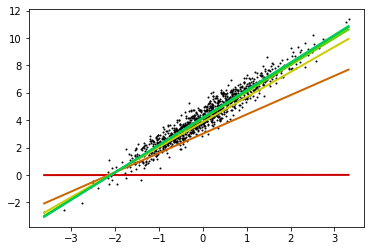

In [ ]:
x1 = min(features[:, 0])
x2 = max(features[:, 0])
fig = plt.figure()
plt.scatter(features[:, 0], labels, 1, color='k');
for i in range(len(w_history)):
    y1, y2 = (w_history[i] * torch.Tensor([[x1], [x2]]) + b_history[i]).detach().numpy()
    plt.plot([x1, x2], [y1, y2], color=hsv_to_rgb((0.5*(i/len(w_history)), 1, 0.8)), linewidth=2);

## Implementación en Pytorch

In [4]:
import torch.nn.functional as F
from torch import nn

In [ ]:
true_w = torch.tensor([2.0])
true_b = 4.2
noise = 0.5
features, labels = synthetic_data(true_w, true_b, noise, 1000)

dataset = torch.utils.data.TensorDataset(features, labels)
dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

In [ ]:
class LinReg(nn.Module):
    '''
    Modelo de regresión lineal
    '''
    def __init__(self):
        super(LinReg, self).__init__()
        self.linear = nn.Linear(1, 1)
        
    def forward(self, x):
        out = self.linear(x)
        return out

In [ ]:
model = LinReg()

In [ ]:
# Batch size
batch_size = 8
# Learning rate
lr = 0.005
# Número de epochs de entrenamiento
num_epochs = 5

In [ ]:
# Función de pérdida
loss = nn.MSELoss()
# Optimizador
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [ ]:
# Inicialización de los parámetros
model.linear.weight.data.normal_(0, 0.01)
model.linear.bias.data.fill_(0)

for epoch in range(num_epochs):
    for X, y in dataloader:
        l = loss(model(X) ,y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    l = loss(model(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 2.054285
epoch 2, loss 0.401637
epoch 3, loss 0.266662
epoch 4, loss 0.255188
epoch 5, loss 0.254660


In [ ]:
model.linear.weight

Parameter containing:
tensor([[1.9924]], requires_grad=True)

In [ ]:
model.linear.bias

Parameter containing:
tensor([4.2261], requires_grad=True)

## Añadir trabajo individual?

# Regresión softmax

## Implementación desde cero

In [3]:
import torchvision

In [4]:
# "ToTensor" convierte las imágenes de tipo PIL a float32
# y divide el resultado entre 255 para restringirlas al rango [0, 1]

image_size = 28

transf = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # Quitar resize?
    torchvision.transforms.Resize((image_size, image_size))
])
mnist_train = torchvision.datasets.FashionMNIST(
    root="data", train=True, transform=transf, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="data", train=False, transform=transf, download=True)

In [5]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [6]:
labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
          'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

In [7]:
batch_size = 256
train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size,
                                               shuffle=True, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size,
                                               shuffle=False, num_workers=1)

$$\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{o})\quad \text{donde}\quad \hat{y}_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}. $$


$$
\operatorname*{argmax}_j \hat y_j = \operatorname*{argmax}_j o_j.
$$

In [15]:
def softmax(X):
    X_exp = torch.exp(X)
    return X_exp / X_exp.sum(1, keepdim=True)

The softmax function gives us a vector $\hat{\mathbf{y}}$,
which we can interpret as estimated conditional probabilities
of each class given any input $\mathbf{x}$, e.g.,
$\hat{y}_1$ = $P(y=\text{cat} \mid \mathbf{x})$.
Suppose that the entire dataset $\{\mathbf{X}, \mathbf{Y}\}$ has $n$ examples,
where the example indexed by $i$
consists of a feature vector $\mathbf{x}^{(i)}$ and a one-hot label vector $\mathbf{y}^{(i)}$.
We can compare the estimates with reality
by checking how probable the actual classes are
according to our model, given the features:

$$
P(\mathbf{Y} \mid \mathbf{X}) = \prod_{i=1}^n P(\mathbf{y}^{(i)} \mid \mathbf{x}^{(i)}).
$$

According to maximum likelihood estimation,
we maximize $P(\mathbf{Y} \mid \mathbf{X})$,
which is
equivalent to minimizing the negative log-likelihood:

$$
-\log P(\mathbf{Y} \mid \mathbf{X}) = \sum_{i=1}^n -\log P(\mathbf{y}^{(i)} \mid \mathbf{x}^{(i)})
= \sum_{i=1}^n l(\mathbf{y}^{(i)}, \hat{\mathbf{y}}^{(i)}),
$$

where for any pair of label $\mathbf{y}$ and model prediction $\hat{\mathbf{y}}$ over $q$ classes,
the loss function $l$ is

$$ l(\mathbf{y}, \hat{\mathbf{y}}) = - \sum_{j=1}^q y_j \log \hat{y}_j. $$

Función de pérdida cross-entropy

In [8]:
def cross_entropy(y_pred, y):
    return - torch.log(y_pred[range(len(y_pred)), y])

Red para entrenamiento

In [16]:
num_inputs = 784
num_outputs = 10

w = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

def net(x, w, b):
    return softmax(torch.matmul(x.reshape((-1, w.shape[0])), w) + b)

In [17]:
x, y = next(iter(test_dataloader))

In [18]:
x.shape

torch.Size([256, 1, 28, 28])

In [19]:
y.shape

torch.Size([256])

In [20]:
y_pred = net(x, w, b)

In [21]:
y_pred.shape

torch.Size([256, 10])

Métrica de precisión

In [22]:
def accuracy(y_pred, y):
    """
    Cálculo del número de predicciones correctas
    """

    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = y_pred.argmax(axis=1)
    tmp = y_pred.type(y.dtype) == y
    return int(tmp.type(y.dtype).sum())

In [23]:
accuracy(y_pred, y) / len(y_pred)

0.12890625

In [27]:
# Learning rate
lr = 0.01
# Número de epochs de entrenamiento
num_epochs = 10
# Modelo a optimizar
model = net
# Función de pérdida cross_entropy
loss = cross_entropy

for epoch in range(num_epochs):
    for x, y in train_dataloader:
        # Predicción del modelo
        y_pred = model(x, w, b)

        # Cálculo de la función de pérdida
        l = loss(y_pred, y)

        # Cálculo de los gradientes (derivadas) de la función de pérdida respecto
        # de los parámetros del modelo
        l.sum().backward()

        # Actualización de los parámetros según sus gradientes
        sgd([w, b], lr, batch_size)

    # Métrica de precisión del modelo
    with torch.no_grad():
        n_correct = 0
        for x, y in train_dataloader:
            y_pred = model(x, w, b)
            l = loss(y_pred, y)
            n_correct += accuracy(y_pred, y)

        print('Epoch {}, Precisión (train): {:.3f}, Loss (train): {:.4f}'.format(epoch,
                                                         n_correct/train_dataloader.dataset.data.shape[0],
                                                         l.mean()))
        n_correct = 0
        for x, y in test_dataloader:
            y_pred = model(x, w, b)
            l = loss(y_pred, y)
            n_correct += accuracy(y_pred, y)

        print('Epoch {}, Precisión (test): {:.3f}, Loss (test): {:.4f}'.format(epoch,
                                                         n_correct/test_dataloader.dataset.data.shape[0],
                                                         l.mean()))

        print(' ')

Epoch 0, Precisión (train): 0.774, Loss (train): 0.6405
Epoch 0, Precisión (test): 0.760, Loss (test): 0.5257
 
Epoch 1, Precisión (train): 0.786, Loss (train): 0.7956
Epoch 1, Precisión (test): 0.770, Loss (test): 0.4848
 
Epoch 2, Precisión (train): 0.792, Loss (train): 0.6995
Epoch 2, Precisión (test): 0.776, Loss (test): 0.4540
 
Epoch 3, Precisión (train): 0.798, Loss (train): 0.6245
Epoch 3, Precisión (test): 0.784, Loss (test): 0.4336
 
Epoch 4, Precisión (train): 0.802, Loss (train): 0.7332
Epoch 4, Precisión (test): 0.789, Loss (test): 0.4163
 
Epoch 5, Precisión (train): 0.804, Loss (train): 0.5056
Epoch 5, Precisión (test): 0.792, Loss (test): 0.4061
 
Epoch 6, Precisión (train): 0.808, Loss (train): 0.5885
Epoch 6, Precisión (test): 0.794, Loss (test): 0.3953
 
Epoch 7, Precisión (train): 0.811, Loss (train): 0.7116
Epoch 7, Precisión (test): 0.800, Loss (test): 0.3848
 
Epoch 8, Precisión (train): 0.814, Loss (train): 0.5985
Epoch 8, Precisión (test): 0.801, Loss (test): 0

In [88]:
x, y = next(iter(train_dataloader))
y_pred = model(x, w, b)

Predicción: t-shirt
Real: t-shirt


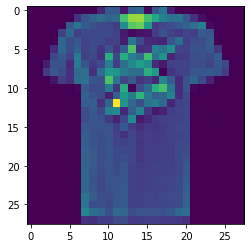

In [95]:
i = random.randint(0, len(x)-1)
plt.imshow(x[i, 0]);
print('Predicción: {}'.format(labels[y_pred.argmax(dim=1)[i]]))
print('Real: {}'.format(labels[y[i]]))

## Implementación en pytorch

In [53]:
import string

image_size = 28

# transf = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor()
#     # torchvision.transforms.Resize((image_size, image_size))
# ])

transf = torchvision.transforms.Compose([
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    torchvision.transforms.ToTensor()
])

emnist_train = torchvision.datasets.EMNIST(
    root="data", split='balanced', train=True, transform=transf, download=True)
emnist_test = torchvision.datasets.EMNIST(
    root="data", split='balanced', train=False, transform=transf, download=True)

train_dataloader = torch.utils.data.DataLoader(emnist_train, batch_size,
                                               shuffle=True, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(emnist_test, batch_size,
                                               shuffle=False, num_workers=1)

labels = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'

In [54]:
len(list(labels))

47

In [5]:
class LinReg(nn.Module):
    '''
    Modelo de regresión lineal
    '''
    def __init__(self):
        super(LinReg, self).__init__()
        self.linear = nn.Linear(28 ** 2, 47)
        
    def forward(self, x):
        out = self.linear(x)
        return out

In [80]:
x, y = next(iter(train_dataloader))

M


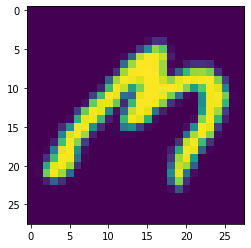

In [94]:
i = random.randint(0, len(labels)-1)
plt.imshow(x[i, 0]);
print(labels[y[i]])

In [59]:
y[i]

tensor(26)

In [117]:
# Batch size
batch_size = 256
# Learning rate
lr = 0.005
# Número de epochs de entrenamiento
num_epochs = 10

In [6]:
model = LinReg()

In [107]:
# Función de pérdida
loss = nn.CrossEntropyLoss()
# Optimizador
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [109]:
x.shape

torch.Size([256, 1, 28, 28])

In [118]:
for epoch in range(num_epochs):
    for x, y in train_dataloader:
        l = loss(model(x.reshape((-1, 28**2))),y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

    with torch.no_grad():
        n_correct = 0
        for x, y in train_dataloader:
            y_pred = model(x.reshape((-1, 28**2)))
            l = loss(y_pred, y)
            n_correct += accuracy(y_pred, y)

        print('Epoch {}, Precisión (train): {:.3f}, Loss (train): {:.4f}'.format(epoch,
                                                         n_correct/train_dataloader.dataset.data.shape[0],
                                                         l.mean()))
        
        n_correct = 0
        for x, y in test_dataloader:
            y_pred = model(x.reshape((-1, 28**2)))
            l = loss(y_pred, y)
            n_correct += accuracy(y_pred, y)

        print('Epoch {}, Precisión (test): {:.3f}, Loss (test): {:.4f}'.format(epoch,
                                                         n_correct/test_dataloader.dataset.data.shape[0],
                                                         l.mean()))

        print(' ')

Epoch 0, Precisión (train): 0.552, Loss (train): 2.0438
Epoch 0, Precisión (test): 0.548, Loss (test): 2.0387
 
Epoch 1, Precisión (train): 0.558, Loss (train): 2.0002
Epoch 1, Precisión (test): 0.555, Loss (test): 1.9690
 
Epoch 2, Precisión (train): 0.564, Loss (train): 1.8011
Epoch 2, Precisión (test): 0.560, Loss (test): 1.9116
 
Epoch 3, Precisión (train): 0.569, Loss (train): 1.9292
Epoch 3, Precisión (test): 0.565, Loss (test): 1.8622
 
Epoch 4, Precisión (train): 0.573, Loss (train): 1.9895
Epoch 4, Precisión (test): 0.570, Loss (test): 1.8209
 
Epoch 5, Precisión (train): 0.578, Loss (train): 1.7782
Epoch 5, Precisión (test): 0.574, Loss (test): 1.7856
 
Epoch 6, Precisión (train): 0.581, Loss (train): 1.5956
Epoch 6, Precisión (test): 0.578, Loss (test): 1.7569
 
Epoch 7, Precisión (train): 0.584, Loss (train): 1.8080
Epoch 7, Precisión (test): 0.581, Loss (test): 1.7291
 
Epoch 8, Precisión (train): 0.588, Loss (train): 1.6674
Epoch 8, Precisión (test): 0.584, Loss (test): 1

## Añadir trabajo individual

# Guardado y carga de modelos

In [14]:
import random
import torch
import os
from torchsummary import summary

In [9]:
os.makedirs('models', exist_ok=True)

In [10]:
torch.save(model, 'models/softmax_reg.pth')

In [12]:
model2 = torch.load('models/softmax_reg.pth')

In [20]:
summary(model2, input_size=(1, 28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 47]          36,895
Total params: 36,895
Trainable params: 36,895
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.14
Estimated Total Size (MB): 0.14
----------------------------------------------------------------


In [22]:
28*28*47 + 47

36895

# Análisis exploratorio de datos

## Introducción

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt

In [2]:
df = pd.read_json('/content/sample_data/anscombe.json')

In [3]:
df.head()

,Series,X,Y
0,I,10,8.04
1,I,8,6.95
2,I,13,7.58
3,I,9,8.81
4,I,11,8.33


In [4]:
x1, y1 = df[df['Series'] == 'I']['X'], df[df['Series'] == 'I']['Y']
x2, y2 = df[df['Series'] == 'II']['X'], df[df['Series'] == 'II']['Y']
x3, y3 = df[df['Series'] == 'III']['X'], df[df['Series'] == 'III']['Y']
x4, y4 = df[df['Series'] == 'IV']['X'], df[df['Series'] == 'IV']['Y']

In [5]:
print('Media aritmética     x1: {:.2f}, x2: {:.2f}, x3: {:.2f}, x4: {:.2f}'.format(x1.mean(), x2.mean(), x3.mean(), x4.mean()))
print('Varianza             x1: {:.2f}, x2: {:.2f}, x3: {:.2f}, x4: {:.2f}'.format(x1.var(), x2.var(), x3.var(), x4.var()))
print('Media aritmética     y1: {:.2f}, y2: {:.2f}, y3: {:.2f}, y4: {:.2f}'.format(y1.mean(), y2.mean(), y3.mean(), y4.mean()))
print('Varianza             y1: {:.2f}, y2: {:.2f}, y3: {:.2f}, y4: {:.2f}'.format(y1.var(), y2.var(), y3.var(), y4.var()))
print('Coef. correlación    r1: {:.2f}, r2: {:.2f}, r3: {:.2f}, r4: {:.2f}'.format(np.corrcoef(x1, y1)[0, 1],
                                                                                   np.corrcoef(x2, y2)[0, 1],
                                                                                   np.corrcoef(x3, y3)[0, 1],
                                                                                   np.corrcoef(x4, y4)[0, 1]))

Media aritmética     x1: 9.00, x2: 9.00, x3: 9.00, x4: 9.00
Varianza             x1: 11.00, x2: 11.00, x3: 11.00, x4: 11.00
Media aritmética     y1: 7.50, y2: 7.50, y3: 7.50, y4: 7.50
Varianza             y1: 4.13, y2: 4.13, y3: 4.12, y4: 4.12
Coef. correlación    r1: 0.82, r2: 0.82, r3: 0.82, r4: 0.82


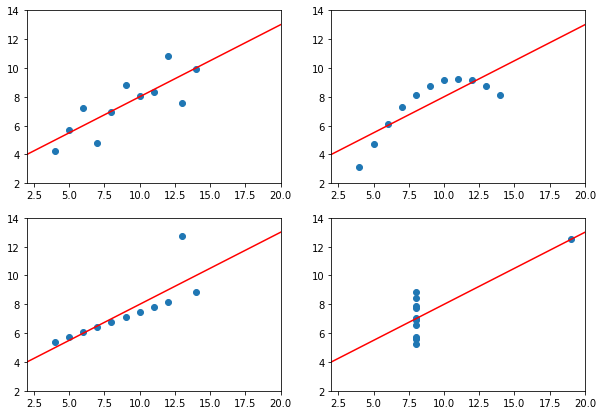

In [12]:
# plt.rcParams["figure.figsize"] = [8, 5]
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)

fig, ax = plt.subplots(2, 2, figsize=(10, 7))
ax[0, 0].scatter(x1, y1);
ax[0, 0].plot([2, 20], [4, 13], 'r');
ax[0, 1].scatter(x2, y2);
ax[0, 1].plot([2, 20], [4, 13], 'r');
ax[1, 0].scatter(x3, y3);
ax[1, 0].plot([2, 20], [4, 13], 'r');
ax[1, 1].scatter(x4, y4);
ax[1, 1].plot([2, 20], [4, 13], 'r');

plt.setp(ax, xlim=[2, 20], ylim=[2, 14]);

## California (cambiar a otro dataset de scipy o similar?)

In [14]:
df_train = pd.read_csv('/content/sample_data/california_housing_train.csv')

In [6]:
df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [9]:
df_train.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
16995    False
16996    False
16997    False
16998    False
16999    False
Length: 17000, dtype: bool

In [84]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


In [85]:
df_train.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


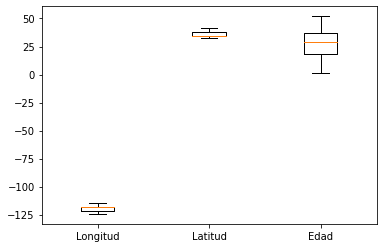

In [12]:
plt.boxplot([df_train['longitude'], df_train['latitude'], df_train['housing_median_age']],
            labels=['Longitud', 'Latitud', 'Edad']);

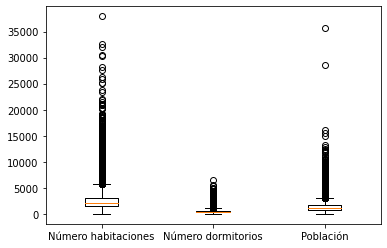

In [15]:
plt.boxplot([df_train['total_rooms'], df_train['total_bedrooms'], df_train['population']],
            labels=['Número habitaciones', 'Número dormitorios', 'Población']);

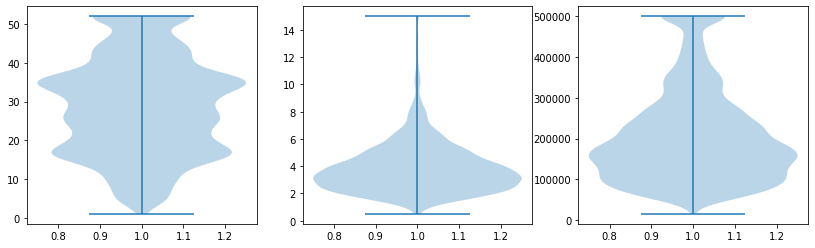

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].violinplot(df_train['housing_median_age']);
ax[1].violinplot(df_train['median_income']);
ax[2].violinplot(df_train['median_house_value']);

In [28]:
df_train.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.925208,-0.114250,0.047010,0.071802,0.101674,0.059628,-0.015485,-0.044982
latitude,-0.925208,1.000000,0.016454,-0.038773,-0.069373,-0.111261,-0.074902,-0.080303,-0.144917
housing_median_age,-0.114250,0.016454,1.000000,-0.360984,-0.320434,-0.295890,-0.302754,-0.115932,0.106758
total_rooms,0.047010,-0.038773,-0.360984,1.000000,0.928403,0.860170,0.919018,0.195383,0.130991
total_bedrooms,0.071802,-0.069373,-0.320434,0.928403,1.000000,0.881169,0.980920,-0.013495,0.045783
population,0.101674,-0.111261,-0.295890,0.860170,0.881169,1.000000,0.909247,-0.000638,-0.027850
households,0.059628,-0.074902,-0.302754,0.919018,0.980920,0.909247,1.000000,0.007644,0.061031
median_income,-0.015485,-0.080303,-0.115932,0.195383,-0.013495,-0.000638,0.007644,1.000000,0.691871
median_house_value,-0.044982,-0.144917,0.106758,0.130991,0.045783,-0.027850,0.061031,0.691871,1.000000


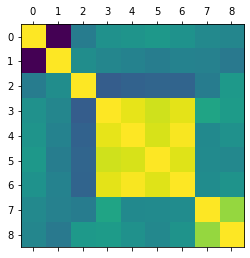

In [27]:
plt.matshow(df_train.corr())